# SWR

Toward a flexible framework for safe withdrawal rate experiments.

Try to easily generalize to
- Any generator of asset returns
- Any asset allocation strategy based on age, returns etc.
- Any utility function to evaluate suitability of strategy (e.g. total spending, certainty equivalent spending)
- Support survival table 
- Any optimizer to find optimal parameters for a given withdrawal framework and market simulation


In [1]:
import pytest
import numpy as np
import pandas as pd
import pandas_datareader as pdr

from SWRsimulator import SWRsimulator



In [2]:
# 2) run a single simulation and do a test
# 3) do multiple sims ... test you get same indiv sims
# 4) do monte carlo

# 5) certainty_equivalent
# 6) certainty_equivalent with mortality

# class simulator

# takes n x m dataframe of returns
# takes k x m+2 dataframe of weights, fixed pct, variable pct
# monte carlo=True/False in range(n), sample n without replacement
# replacement = true/false

# simulate 
#   actual_year= value in range(n-k+1)
    
# simulate_many
#   startyear
#   nyears
#   returns list of nyears dataframes n x m with the cash flows
    
# simulate_many_mc
#   n_trials
#   returns list of n_trials dataframes n x m with the cash flows
  
# certainty_equivalent(k_list)
#   - first each cash flow stream
#   - then over all streams, equal-weighted

# certainty_equivalent_mortality(k_list, mortality_table)
# calculate probability of being alive in years 1...k
# so now you have k lists with associated probabilities
#    certainty_adjust cash flow streams
#    not just full cash flow but range(nyears) cash flows 
#    then certainty adjust over the probability distribution of each sequence of cash flows
    

In [3]:
# load spreadsheet from Damodaran website into pandas dataframe
# data_xls = 'http://www.stern.nyu.edu/~adamodar/pc/datasets/histretSP.xls'
# data_sheet = "Returns by year"
# # these will change as rows get added on Damodaran website
# skiprows = range(17)
# skipfooter = 10
# download_df = pd.read_excel(data_xls, 
#                          sheet_name=data_sheet, 
#                          skiprows=skiprows,
#                          skipfooter=skipfooter)
# download_df = download_df.set_index('Year')
# download_df.to_pickle('histretSP.pickle')

# load from pickle
RETURN_FILE = 'histretSP'
def load_returns():
    return pd.read_pickle('%s.pickle' % RETURN_FILE)

download_df = load_returns()
return_df = download_df.iloc[:, [0, 2, 12]]
return_df.columns=['stocks', 'tbonds', 'cpi']
return_df


,stocks,tbonds,cpi
Year,,,
1928,0.438112,0.008355,-0.011522
1929,-0.082979,0.042038,0.000000
1930,-0.251236,0.045409,-0.026712
1931,-0.438375,-0.025589,-0.089321
1932,-0.086424,0.087903,-0.103014
...,...,...,...
2016,0.117731,0.006906,0.012616
2017,0.216055,0.028017,0.021301
2018,-0.042269,-0.000167,0.024426


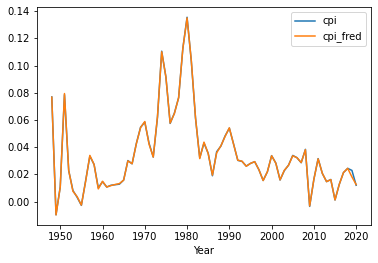

In [4]:
# damodaran sheet apparently has average cpi over the year

series = ['CPIAUCSL']

cpi_download = pdr.data.DataReader(series, 
                                   'fred', 
                                   start='1947-01-01')

cpi_download = cpi_download.reset_index()
cpi_download = cpi_download.resample('A', on='DATE').mean().reset_index()
cpi_download = cpi_download.set_index(pd.DatetimeIndex(cpi_download['DATE']).year)

cpi_test = return_df[['cpi']].copy()
cpi_test['cpi_fred'] = cpi_download['CPIAUCSL'].pct_change()
cpi_test = cpi_test.dropna()
cpi_test.plot();

<AxesSubplot:xlabel='Year'>

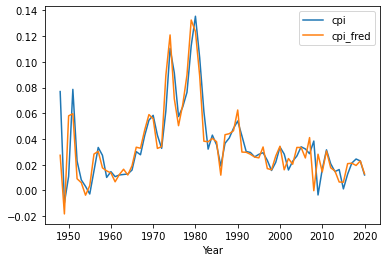

In [5]:
# we will use year-ending (resample to last)

series = ['CPIAUCSL']

cpi_download = pdr.data.DataReader(series, 
                                   'fred', 
                                   start='1947-01-01')

cpi_download = cpi_download.reset_index()
cpi_download = cpi_download.resample('A', on='DATE').last()
cpi_download = cpi_download.set_index(pd.DatetimeIndex(cpi_download['DATE']).year)

cpi_test = return_df[['cpi']].copy()
cpi_test['cpi_fred'] = cpi_download['CPIAUCSL'].pct_change()
cpi_test = cpi_test.dropna()
cpi_test.plot()

In [6]:
# should adjust 1928-1947 also but leave it for now
real_return_df = return_df.copy()
real_return_df.loc[1948:, 'cpi'] = cpi_test['cpi_fred']
# adjust returns for inflation
real_return_df['stocks'] = (1 + real_return_df['stocks']) / (1 + real_return_df['cpi']) - 1
real_return_df['tbonds'] = (1 + real_return_df['tbonds']) / (1 + real_return_df['cpi']) - 1
real_return_df.drop('cpi', axis=1, inplace=True)
real_return_df

,stocks,tbonds
Year,,
1928,0.454874,0.020108
1929,-0.082979,0.042038
1930,-0.230686,0.074101
1931,-0.383290,0.069984
1932,0.018495,0.212842
...,...,...
2016,0.094931,-0.013634
2017,0.190860,0.006718
2018,-0.060487,-0.019186


In [7]:
def trial_generator(df, start_year, n_years):
    """given a dataframe of returns, starting year, number of years, generate schedule of returns"""
    for t in df.loc[start_year:start_year+n_years-1].itertuples():
        yield tuple(t)
        
for t in trial_generator(real_return_df, 1928, 30):
    print(t)
        

(1928, 0.45487432249783444, 0.020108191146551713)
(1929, -0.08297946611909657, 0.04203804156320423)
(1930, -0.230686460365651, 0.07410069203459857)
(1931, -0.38329009698686445, 0.06998390033605428)
(1932, 0.018495326717702376, 0.21284245913764055)
(1933, 0.581964662036228, 0.0743369130670235)
(1934, -0.045109911724357965, 0.04333290958996461)
(1935, 0.43087497405126873, 0.018713436365558778)
(1936, 0.305954303623881, 0.03944976149722845)
(1937, -0.3765951045848651, -0.02262513589032067)
(1938, 0.3195852213616539, 0.06370234790305918)
(1939, 0.0020612704549900496, 0.0578858141730334)
(1940, -0.11310541531662999, 0.046500581432404875)
(1941, -0.17016872385326265, -0.06790781217757547)
(1942, 0.07438793010933531, -0.07778046921017512)
(1943, 0.1801644808284768, -0.03283391552975834)
(1944, 0.17113551533549098, 0.009254812155054415)
(1945, 0.32801445079139935, 0.014965879256698456)
(1946, -0.15584345006195166, -0.04929908982232878)
(1947, -0.08033444704365555, -0.11775314859755615)
(1948, 

In [8]:
# zero returns, zero spending (just check shape)

zero_df = real_return_df.copy()
zero_df['stocks'] = 0.0
zero_df['tbonds'] = 0.0

trials = [trial_generator(zero_df, 1928, 30)]

s = SWRsimulator.SWRsimulator({
    'simulator': {'n_ret_years': 30,
                  'n_assets': 2,
                  'trials': trials},
    'allocation': {},
    'spending': {'fixed_pct': 0.0,
                 'variable_pct': 0.0},
    'evaluation': {},
    })

print(s)

z = s.simulate_trial(trial_generator(zero_df, 1928, 30))
assert len(z) == 30
assert(z.index[0]) == 1928, "start year == 1928"
assert(z.index[-1]) == 1957, "end year == 1957"

z

Simulator:
{'n_assets': 2,
 'n_ret_years': 30,
 'trials': [<generator object trial_generator at 0x7ff748c21b50>]}

Allocation:
{}

Spending:
{'fixed_pct': 0.0, 'variable_pct': 0.0}


,start_port,port_return,before_spend,spend,end_port,alloc_0,alloc_1
1928,100.0,0.0,100.0,0.0,100.0,0.5,0.5
1929,100.0,0.0,100.0,0.0,100.0,0.5,0.5
1930,100.0,0.0,100.0,0.0,100.0,0.5,0.5
1931,100.0,0.0,100.0,0.0,100.0,0.5,0.5
1932,100.0,0.0,100.0,0.0,100.0,0.5,0.5
1933,100.0,0.0,100.0,0.0,100.0,0.5,0.5
1934,100.0,0.0,100.0,0.0,100.0,0.5,0.5
1935,100.0,0.0,100.0,0.0,100.0,0.5,0.5
1936,100.0,0.0,100.0,0.0,100.0,0.5,0.5
1937,100.0,0.0,100.0,0.0,100.0,0.5,0.5


In [9]:
# zero returns, spend 2% per year, check ending value declines to 0.4
RETURN = 0.0
FIXED = 2.0
VARIABLE = 0.00
NYEARS = 30

return_df = real_return_df.copy()
return_df['stocks'] = RETURN
return_df['tbonds'] = RETURN

trials = [trial_generator(zero_df, 1928, NYEARS)]

s = SWRsimulator.SWRsimulator({
    'simulator': {'n_ret_years': NYEARS,
                  'n_assets': 2,
                  'trials': trials},
    'allocation': {},
    'spending': {'fixed_pct': FIXED,
                 'variable_pct': VARIABLE},
    'evaluation': {},
    })

print(s)

z = s.simulate_trial(trial_generator(return_df, 1928, 30))

assert(z['start_port'].iloc[0]) == 100, "start port value == 100"
assert(z['end_port'].iloc[-1]) == 40, "ending port value == 40"

z

Simulator:
{'n_assets': 2,
 'n_ret_years': 30,
 'trials': [<generator object trial_generator at 0x7ff7491637d0>]}

Allocation:
{}

Spending:
{'fixed_pct': 2.0, 'variable_pct': 0.0}


,start_port,port_return,before_spend,spend,end_port,alloc_0,alloc_1
1928,100.0,0.0,100.0,2.0,98.0,0.5,0.5
1929,98.0,0.0,98.0,2.0,96.0,0.5,0.5
1930,96.0,0.0,96.0,2.0,94.0,0.5,0.5
1931,94.0,0.0,94.0,2.0,92.0,0.5,0.5
1932,92.0,0.0,92.0,2.0,90.0,0.5,0.5
1933,90.0,0.0,90.0,2.0,88.0,0.5,0.5
1934,88.0,0.0,88.0,2.0,86.0,0.5,0.5
1935,86.0,0.0,86.0,2.0,84.0,0.5,0.5
1936,84.0,0.0,84.0,2.0,82.0,0.5,0.5
1937,82.0,0.0,82.0,2.0,80.0,0.5,0.5


In [10]:
# zero returns, spend 2% per year, check ending value declines to 0.98 ** 30
RETURN = 0.0
FIXED = 0
VARIABLE = 2.0
NYEARS = 30

return_df = real_return_df.copy()
return_df['stocks'] = RETURN
return_df['tbonds'] = RETURN

trials = [trial_generator(zero_df, 1928, NYEARS)]

s = SWRsimulator.SWRsimulator({
    'simulator': {'n_ret_years': NYEARS,
                  'n_assets': 2,
                  'trials': trials},
    'allocation': {},
    'spending': {'fixed_pct': FIXED,
                 'variable_pct': VARIABLE},
    'evaluation': {},
    })

print(s)

z = s.simulate_trial(trial_generator(return_df, 1928, 30))

assert(z['start_port'].iloc[0]) == 100, "start port value == 100"
assert z['end_port'].iloc[-1] == pytest.approx(100 * ((1 - VARIABLE/100) ** NYEARS), 0.000001)
z

Simulator:
{'n_assets': 2,
 'n_ret_years': 30,
 'trials': [<generator object trial_generator at 0x7ff749163dd0>]}

Allocation:
{}

Spending:
{'fixed_pct': 0, 'variable_pct': 2.0}


,start_port,port_return,before_spend,spend,end_port,alloc_0,alloc_1
1928,100.000000,0.0,100.000000,2.000000,98.000000,0.5,0.5
1929,98.000000,0.0,98.000000,1.960000,96.040000,0.5,0.5
1930,96.040000,0.0,96.040000,1.920800,94.119200,0.5,0.5
1931,94.119200,0.0,94.119200,1.882384,92.236816,0.5,0.5
1932,92.236816,0.0,92.236816,1.844736,90.392080,0.5,0.5
1933,90.392080,0.0,90.392080,1.807842,88.584238,0.5,0.5
1934,88.584238,0.0,88.584238,1.771685,86.812553,0.5,0.5
1935,86.812553,0.0,86.812553,1.736251,85.076302,0.5,0.5
1936,85.076302,0.0,85.076302,1.701526,83.374776,0.5,0.5
1937,83.374776,0.0,83.374776,1.667496,81.707281,0.5,0.5


In [11]:
# 4% real return, spend fixed 4% of starting, assert ending value unchanged
RETURN = 0.04
FIXED = 4 
VARIABLE = 0.0
NYEARS = 30

return_df = real_return_df.copy()
return_df['stocks'] = RETURN
return_df['tbonds'] = RETURN

trials = [trial_generator(zero_df, 1928, NYEARS)]

s = SWRsimulator.SWRsimulator({
    'simulator': {'n_ret_years': 30,
                  'n_assets': 2,
                  'trials': trials},
    'allocation': {},
    'spending': {'fixed_pct': FIXED,
                 'variable_pct': VARIABLE},
    'evaluation': {},
    })

print(s)

z = s.simulate_trial(trial_generator(return_df, 1928, 30))

assert(z['start_port'].iloc[0]) == 100, "start port value == 100"
assert(z['end_port'].iloc[-1]) == 100, "end port value correct"
z


Simulator:
{'n_assets': 2,
 'n_ret_years': 30,
 'trials': [<generator object trial_generator at 0x7ff7491638d0>]}

Allocation:
{}

Spending:
{'fixed_pct': 4, 'variable_pct': 0.0}


,start_port,port_return,before_spend,spend,end_port,alloc_0,alloc_1
1928,100.0,0.04,104.0,4.0,100.0,0.5,0.5
1929,100.0,0.04,104.0,4.0,100.0,0.5,0.5
1930,100.0,0.04,104.0,4.0,100.0,0.5,0.5
1931,100.0,0.04,104.0,4.0,100.0,0.5,0.5
1932,100.0,0.04,104.0,4.0,100.0,0.5,0.5
1933,100.0,0.04,104.0,4.0,100.0,0.5,0.5
1934,100.0,0.04,104.0,4.0,100.0,0.5,0.5
1935,100.0,0.04,104.0,4.0,100.0,0.5,0.5
1936,100.0,0.04,104.0,4.0,100.0,0.5,0.5
1937,100.0,0.04,104.0,4.0,100.0,0.5,0.5


In [12]:
# return 0.02% variable spending 0.02/1.02, check final value unchanged
RETURN = 0.02
FIXED = 0.0
VARIABLE = 0.02/1.02*100
NYEARS = 30

return_df = real_return_df.copy()
return_df['stocks'] = RETURN
return_df['tbonds'] = RETURN

trials = [trial_generator(zero_df, 1928, NYEARS)]

s = SWRsimulator.SWRsimulator({
    'simulator': {'n_ret_years': 30,
                  'n_assets': 2,
                  'trials': trials},
    'allocation': {},
    'spending': {'fixed_pct': FIXED,
                 'variable_pct': VARIABLE},
    'evaluation': {},
    })

print(s)

z = s.simulate_trial(trial_generator(return_df, 1928, 30))

assert (z['start_port'].iloc[0]) == 100, "start port value == 100"
assert (z['end_port'].iloc[-1]) == 100, "end port value correct"
z


Simulator:
{'n_assets': 2,
 'n_ret_years': 30,
 'trials': [<generator object trial_generator at 0x7ff761ac6250>]}

Allocation:
{}

Spending:
{'fixed_pct': 0.0, 'variable_pct': 1.9607843137254901}


,start_port,port_return,before_spend,spend,end_port,alloc_0,alloc_1
1928,100.0,0.02,102.0,2.0,100.0,0.5,0.5
1929,100.0,0.02,102.0,2.0,100.0,0.5,0.5
1930,100.0,0.02,102.0,2.0,100.0,0.5,0.5
1931,100.0,0.02,102.0,2.0,100.0,0.5,0.5
1932,100.0,0.02,102.0,2.0,100.0,0.5,0.5
1933,100.0,0.02,102.0,2.0,100.0,0.5,0.5
1934,100.0,0.02,102.0,2.0,100.0,0.5,0.5
1935,100.0,0.02,102.0,2.0,100.0,0.5,0.5
1936,100.0,0.02,102.0,2.0,100.0,0.5,0.5
1937,100.0,0.02,102.0,2.0,100.0,0.5,0.5


In [13]:
# per appendix of Bengen paper https://www.retailinvestor.org/pdf/Bengen1.pdf
# nominal return 10% for stocks, 5% for bonds
# inflation 3%
# fixed spending of 4% of orig port
STOCK_RETURN = (1.1 / 1.03) - 1
BOND_RETURN = (1.05 / 1.03) - 1
VARIABLE = 0.0
FIXED = 4.0
NYEARS = 30

return_df = real_return_df.copy()
return_df['stocks'] = STOCK_RETURN
return_df['tbonds'] = BOND_RETURN

trials = [trial_generator(zero_df, 1928, NYEARS)]

s = SWRsimulator.SWRsimulator({
    'simulator': {'n_ret_years': NYEARS,
                  'n_assets': 2,
                  'trials': trials},
    'allocation': {},
    'spending': {'fixed_pct': FIXED,
                 'variable_pct': VARIABLE},
    'evaluation': {},
    })

print(s)

z = s.simulate_trial(trial_generator(return_df, 1928, 30))
# match figures in appendix
# example uses nominal vals with 3% inflation, we use real vals
assert z.iloc[0]['before_spend'] * 1.03 == pytest.approx(107.5, 0.000001)
assert z.iloc[0]['spend'] * 1.03 == 4.12, "spend does not match Bengen"
assert z.iloc[0]['end_port'] * 1.03 == pytest.approx(103.38, 0.000001), "ending port does not match Bengen"

z

Simulator:
{'n_assets': 2,
 'n_ret_years': 30,
 'trials': [<generator object trial_generator at 0x7ff761ac6b50>]}

Allocation:
{}

Spending:
{'fixed_pct': 4.0, 'variable_pct': 0.0}


,start_port,port_return,before_spend,spend,end_port,alloc_0,alloc_1
1928,100.000000,0.043689,104.368932,4.0,100.368932,0.5,0.5
1929,100.368932,0.043689,104.753982,4.0,100.753982,0.5,0.5
1930,100.753982,0.043689,105.155855,4.0,101.155855,0.5,0.5
1931,101.155855,0.043689,105.575286,4.0,101.575286,0.5,0.5
1932,101.575286,0.043689,106.013041,4.0,102.013041,0.5,0.5
1933,102.013041,0.043689,106.469922,4.0,102.469922,0.5,0.5
1934,102.469922,0.043689,106.946763,4.0,102.946763,0.5,0.5
1935,102.946763,0.043689,107.444437,4.0,103.444437,0.5,0.5
1936,103.444437,0.043689,107.963854,4.0,103.963854,0.5,0.5
1937,103.963854,0.043689,108.505964,4.0,104.505964,0.5,0.5


In [14]:
def all_historical_trials(df, n_years):
    """generate all feasible n_years trials available in df"""
    start_year = df.index[0]
    end_year = df.index[-1] - 30 + 1
    
    for year in range(start_year, end_year + 1):
        yield trial_generator(df, year, n_years)    
    

for g in all_historical_trials(real_return_df, 30):
    for t in g:
        print(t)
    print("---")


(1928, 0.45487432249783444, 0.020108191146551713)
(1929, -0.08297946611909657, 0.04203804156320423)
(1930, -0.230686460365651, 0.07410069203459857)
(1931, -0.38329009698686445, 0.06998390033605428)
(1932, 0.018495326717702376, 0.21284245913764055)
(1933, 0.581964662036228, 0.0743369130670235)
(1934, -0.045109911724357965, 0.04333290958996461)
(1935, 0.43087497405126873, 0.018713436365558778)
(1936, 0.305954303623881, 0.03944976149722845)
(1937, -0.3765951045848651, -0.02262513589032067)
(1938, 0.3195852213616539, 0.06370234790305918)
(1939, 0.0020612704549900496, 0.0578858141730334)
(1940, -0.11310541531662999, 0.046500581432404875)
(1941, -0.17016872385326265, -0.06790781217757547)
(1942, 0.07438793010933531, -0.07778046921017512)
(1943, 0.1801644808284768, -0.03283391552975834)
(1944, 0.17113551533549098, 0.009254812155054415)
(1945, 0.32801445079139935, 0.014965879256698456)
(1946, -0.15584345006195166, -0.04929908982232878)
(1947, -0.08033444704365555, -0.11775314859755615)
(1948, 

(1956, 0.044842448077068386, -0.04944359119481179)
(1957, -0.13099292659285444, 0.03645994553995391)
(1958, 0.41239458699676645, -0.03788714099318846)
(1959, 0.10379991976479275, -0.041031250451289636)
(1960, -0.010098120225893292, 0.10141489552205041)
(1961, 0.2579374286182696, 0.013807413953855097)
(1962, -0.09922051682646404, 0.0440629549245537)
(1963, 0.20626630352758601, 0.0003772162586597183)
(1964, 0.1503709688083179, 0.02499924602842829)
(1965, 0.10281831316597434, -0.011785173728486975)
(1966, -0.12897171701247367, -0.004368797479375908)
(1967, 0.19870401694480866, -0.04706883620554658)
(1968, 0.05834419386361023, -0.013669362462749413)
(1969, -0.13352594438238374, -0.10305043921149515)
(1970, -0.01903136609617695, 0.10594311352126784)
(1971, 0.1060831586076334, 0.06314318381132589)
(1972, 0.14843421548460678, -0.005685116241579191)
(1973, -0.21341080261228396, -0.04848957978344737)
(1974, -0.33896968791262616, -0.09015942533778187)
(1975, 0.2787855424120447, -0.03289340611958

(1987, 0.014191138227843014, -0.08906785383410265)
(1988, 0.11613086073507572, 0.03650767850097525)
(1989, 0.25645721814175326, 0.12475243168211869)
(1990, -0.08770791644632447, -0.00018420978928557208)
(1991, 0.2646538313097586, 0.11675870076839523)
(1992, 0.043965790989664244, 0.062106695509482224)
(1993, 0.069604335303447, 0.11088306664061087)
(1994, -0.012392925042503777, -0.10364841486416332)
---
(1966, -0.12897171701247367, -0.004368797479375908)
(1967, 0.19870401694480866, -0.04706883620554658)
(1968, 0.05834419386361023, -0.013669362462749413)
(1969, -0.13352594438238374, -0.10305043921149515)
(1970, -0.01903136609617695, 0.10594311352126784)
(1971, 0.1060831586076334, 0.06314318381132589)
(1972, 0.14843421548460678, -0.005685116241579191)
(1973, -0.21341080261228396, -0.04848957978344737)
(1974, -0.33896968791262616, -0.09015942533778187)
(1975, 0.2787855424120447, -0.03289340611958358)
(1976, 0.17893896310224844, 0.10423657145646459)
(1977, -0.1280280446283495, -0.05050823443

(1994, -0.012392925042503777, -0.10364841486416332)
(1995, 0.3380766312723329, 0.20431871961612003)
(1996, 0.18671280140185065, -0.018864692683561057)
(1997, 0.30882516741602006, 0.08104546516877154)
(1998, 0.2630827761832222, 0.13103939690253563)
(1999, 0.1773431103731451, -0.10645692609635993)
(2000, -0.12053671475636174, 0.12780120794771466)
(2001, -0.13241081996579673, 0.03905878442181043)
(2002, -0.23854658458381273, 0.1233030487940916)
(2003, 0.2579560349914751, -0.016267767151984525)
(2004, 0.07161110785758185, 0.011112249701196175)
(2005, 0.014475988955610086, -0.00455799755732289)
(2006, 0.127663600970086, -0.005491169572031884)
(2007, 0.013216189957117042, 0.0586031896703918)
(2008, -0.3653823782968225, 0.2012798197787895)
(2009, 0.2248826333591174, -0.1354951830866017)
(2010, 0.1319360255952151, 0.0692556555977033)
(2011, -0.009350599443170515, 0.125878206783699)
(2012, 0.1388674233906817, 0.011911093696567177)
(2013, 0.3017573735914698, -0.10459176722795238)
(2014, 0.127877

In [16]:
s.simulator

{'n_ret_years': 30,
 'n_assets': 2,
 'trials': [<generator object trial_generator at 0x7ff761ac6b50>]}

In [17]:
STOCK_RETURN = (1.1 / 1.03) - 1
BOND_RETURN = (1.05 / 1.03) - 1
VARIABLE = 0.0
FIXED = 4.0
NYEARS = 30

return_df = real_return_df.copy()
return_df['stocks'] = STOCK_RETURN
return_df['tbonds'] = BOND_RETURN


s = SWRsimulator.SWRsimulator({
    'simulator': {'n_ret_years': NYEARS,
                  'n_assets': 2,
                  'trials': all_historical_trials(real_return_df, NYEARS)},
    'allocation': {},
    'spending': {'fixed_pct': FIXED,
                 'variable_pct': VARIABLE},
    'evaluation': {},
    })

print(s)

s.simulate()

Simulator:
{'n_assets': 2,
 'n_ret_years': 30,
 'trials': <generator object all_historical_trials at 0x7ff761ac6c50>}

Allocation:
{}

Spending:
{'fixed_pct': 4.0, 'variable_pct': 0.0}


[      start_port  port_return  before_spend  spend    end_port  alloc_0  \
 1928  100.000000     0.237491    123.749126    4.0  119.749126      0.5   
 1929  119.749126    -0.020471    117.297776    4.0  113.297776      0.5   
 1930  113.297776    -0.078293    104.427366    4.0  100.427366      0.5   
 1931  100.427366    -0.156653     84.695108    4.0   80.695108      0.5   
 1932   80.695108     0.115669     90.029022    4.0   86.029022      0.5   
 1933   86.029022     0.328151    114.259513    4.0  110.259513      0.5   
 1934  110.259513    -0.000889    110.161547    4.0  106.161547      0.5   
 1935  106.161547     0.224794    130.026048    4.0  126.026048      0.5   
 1936  126.026048     0.172702    147.791003    4.0  143.791003      0.5   
 1937  143.791003    -0.199610    115.088863    4.0  111.088863      0.5   
 1938  111.088863     0.191644    132.378354    4.0  128.378354      0.5   
 1939  128.378354     0.029974    132.226308    4.0  128.226308      0.5   
 1940  128.2

In [ ]:
# cers simulator should take a generator of generators, that runs all available historical periods
# run bengen historical 4% test
# do similar with monte carlo
# function to return ce value based on strategy
# ce value of a stream
# ce value of many ce streams
# ce value of a set of streams over a mortality curve
# run bayesian optimizaton, optuna etc.
# try convex optimization
# go through the scikit optimizers and see if there are other global optimizers that might work eg simulated annealing
# accept an arbitrary schedule, utility function, optimizer
